# SkyGeni Sales Intelligence - Exploratory Data Analysis
## Part 2: Data Exploration & Insights

**Objective:** Investigate declining win rates in a B2B SaaS sales pipeline and identify root causes.

**Author:** GitHub Copilot
**Date:** 2026-02-09
**Dataset:** 5,000 deals (Jan 2023 - Mar 2024)

**Key Questions:**
1. Why has win rate declined despite healthy pipeline volume?
2. Which segments are underperforming?
3. What metrics can predict revenue outcomes?

### 0. Setup & Configuration
Initialize libraries, plotting defaults, and constants for reproducible analysis.

In [ ]:
"""Import required libraries for data analysis and visualization."""

from __future__ import annotations

from typing import Dict, List
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 2)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 10

DATA_PATH = "../data/raw/skygeni_sales_data.csv"
OVERALL_WIN_RATE_BENCHMARK = 45.0
PERCENT_SCALE = 100.0
OPTIMISM_GAP_ALERT = 50.0
SOURCE_GAP_ALERT = 2.0
CORRELATION_THRESHOLD = 0.1
MILLION = 1_000_000
BAR_WIDTH = 0.35
DEAL_SIZE_BINS = [0, 5000, 15000, 30000, float("inf")]
DEAL_SIZE_LABELS = [
    "Small (<5K)",
    "Medium (5-15K)",
    "Large (15-30K)",
    "Enterprise (30K+)",
]
MIN_DEALS_DIMENSION = 5
MIN_DEALS_REP = 5

### 1. Data Loading & Quality Assessment
Initial ingestion and data quality checks to confirm completeness and schema.

In [4]:
def load_sales_data(filepath: str) -> pd.DataFrame:
    """Load sales data from CSV and validate required columns.

    Args:
        filepath: Path to the sales data CSV file.

    Returns:
        DataFrame containing sales data.

    Raises:
        FileNotFoundError: If the file does not exist.
        ValueError: If required columns are missing.
    """
    required_columns = [
        "deal_id",
        "created_date",
        "closed_date",
        "sales_rep_id",
        "industry",
        "region",
        "product_type",
        "lead_source",
        "deal_stage",
        "deal_amount",
        "sales_cycle_days",
        "outcome",
]
    df_raw = pd.read_csv(filepath)

    missing_cols = set(required_columns) - set(df_raw.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {sorted(missing_cols)}")

    return df_raw

df = load_sales_data(DATA_PATH)

created_dates = pd.to_datetime(df["created_date"], errors="coerce")
print(f"Dataset Shape: {df.shape[0]:,} deals x {df.shape[1]} features")
print(f"Date Range: {created_dates.min()} to {created_dates.max()}")
print("\nColumn Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isna().sum())
print("\nBasic Statistics:\n", df.describe())

Dataset Shape: 5,000 deals x 12 features
Date Range: 2023-01-01 00:00:00 to 2024-03-26 00:00:00

Column Types:
 deal_id               str
created_date          str
closed_date           str
sales_rep_id          str
industry              str
region                str
product_type          str
lead_source           str
deal_stage            str
deal_amount         int64
sales_cycle_days    int64
outcome               str
dtype: object

Missing Values:
 deal_id             0
created_date        0
closed_date         0
sales_rep_id        0
industry            0
region              0
product_type        0
lead_source         0
deal_stage          0
deal_amount         0
sales_cycle_days    0
outcome             0
dtype: int64

Basic Statistics:
        deal_amount  sales_cycle_days
count      5000.00           5000.00
mean      26286.49             63.75
std       27689.23             32.73
min        2002.00              7.00
25%        6611.00             35.75
50%       14171.50       

### 2. Data Preparation & Feature Engineering
Convert data types, create temporal features, and build analysis-friendly segments.

In [5]:
def prepare_sales_data(df_raw: pd.DataFrame) -> pd.DataFrame:
    """Prepare sales data with clean types and engineered features.

    Args:
        df_raw: Raw sales DataFrame.

    Returns:
        Prepared DataFrame with temporal and segment features.
    """
    df_prepared = df_raw.copy()

    date_columns = ["created_date", "closed_date"]
    for col in date_columns:
        df_prepared[col] = pd.to_datetime(df_prepared[col], errors="coerce")

    df_prepared["created_quarter"] = df_prepared["created_date"].dt.to_period("Q")
    df_prepared["closed_quarter"] = df_prepared["closed_date"].dt.to_period("Q")
    df_prepared["created_month"] = df_prepared["created_date"].dt.to_period("M")
    df_prepared["closed_month"] = df_prepared["closed_date"].dt.to_period("M")

    df_prepared["deal_size_segment"] = pd.cut(
        df_prepared["deal_amount"],
        bins=DEAL_SIZE_BINS,
        labels=DEAL_SIZE_LABELS,
        include_lowest=True,
)

    computed_cycle = (
        df_prepared["closed_date"] - df_prepared["created_date"]
    ).dt.days
    df_prepared["sales_cycle_days"] = computed_cycle.where(
        computed_cycle.notna(), df_prepared["sales_cycle_days"]
)

    df_prepared["is_won"] = df_prepared["outcome"].str.lower().eq("won").astype(int)
    df_prepared["won_amount"] = np.where(
        df_prepared["is_won"] == 1, df_prepared["deal_amount"], 0
)

    return df_prepared

df = prepare_sales_data(df)
print("✅ Data preparation complete")
print("New features: created_quarter, closed_quarter, created_month, deal_size_segment")

✅ Data preparation complete
New features: created_quarter, closed_quarter, created_month, deal_size_segment


### 3. Overall Performance Metrics
High-level KPIs to confirm the CRO's concern and set a baseline.

In [6]:
def safe_div(numerator: float, denominator: float) -> float:
    """Safely divide two numbers and return NaN on invalid inputs.

    Args:
        numerator: Numerator value.
        denominator: Denominator value.

    Returns:
        Division result or NaN when denominator is zero or missing.
    """
    if denominator == 0 or pd.isna(denominator):
        return np.nan
    return numerator / denominator

def calculate_overall_metrics(df_prepared: pd.DataFrame) -> Dict[str, float]:
    """Calculate key performance indicators across the dataset.

    Args:
        df_prepared: Prepared sales DataFrame.

    Returns:
        Dictionary containing overall performance metrics.
    """
    total_deals = len(df_prepared)
    won_deals = int(df_prepared["is_won"].sum())
    lost_deals = total_deals - won_deals

    total_revenue = df_prepared.loc[
        df_prepared["is_won"] == 1, "deal_amount"
    ].sum()
    avg_deal_size_won = df_prepared.loc[
        df_prepared["is_won"] == 1, "deal_amount"
    ].mean()
    avg_deal_size_lost = df_prepared.loc[
        df_prepared["is_won"] == 0, "deal_amount"
    ].mean()
    avg_sales_cycle_won = df_prepared.loc[
        df_prepared["is_won"] == 1, "sales_cycle_days"
    ].mean()
    avg_sales_cycle_lost = df_prepared.loc[
        df_prepared["is_won"] == 0, "sales_cycle_days"
    ].mean()
    win_rate_pct = safe_div(won_deals, total_deals) * PERCENT_SCALE

    return {
        "total_deals": total_deals,
        "won_deals": won_deals,
        "lost_deals": lost_deals,
        "win_rate_pct": win_rate_pct,
        "total_revenue": total_revenue,
        "avg_deal_size_won": avg_deal_size_won,
        "avg_deal_size_lost": avg_deal_size_lost,
        "avg_sales_cycle_won": avg_sales_cycle_won,
        "avg_sales_cycle_lost": avg_sales_cycle_lost,
    }

def format_metric(value: float, metric_name: str) -> str:
    """Format metrics for display based on metric type.

    Args:
        value: Metric value.
        metric_name: Metric name to determine formatting.

    Returns:
        Formatted string value.
    """
    if "pct" in metric_name or "rate" in metric_name:
        return f"{value:.2f}%"
    if "revenue" in metric_name:
        return f"${value:,.0f}"
    return f"{value:,.2f}"

overall_metrics = calculate_overall_metrics(df)

print("=" * 80)
print("OVERALL PERFORMANCE METRICS")
print("=" * 80)
for metric, value in overall_metrics.items():
    label = metric.replace("_", " ").title()
    print(f"{label}: {format_metric(value, metric)}")

def analyze_quarterly_trends(df_prepared: pd.DataFrame) -> pd.DataFrame:
    """Analyze win rate trends by quarter.

    Args:
        df_prepared: Prepared sales DataFrame.

    Returns:
        DataFrame with quarterly aggregated metrics.
    """
    df_closed = df_prepared.dropna(subset=["closed_quarter"]).copy()
    quarterly_stats = (
        df_closed.groupby("closed_quarter", as_index=False)
        .agg(
            total_deals=("deal_id", "count"),
            won_deals=("is_won", "sum"),
            total_revenue=("won_amount", "sum"),
            avg_deal_size=("deal_amount", "mean"),
        )
    )
    quarterly_stats["win_rate_pct"] = (
        quarterly_stats["won_deals"] / quarterly_stats["total_deals"] * PERCENT_SCALE
    ).round(2)
    quarterly_stats["lost_deals"] = (
        quarterly_stats["total_deals"] - quarterly_stats["won_deals"]
    )
    quarterly_stats["quarter"] = quarterly_stats["closed_quarter"].astype(str)
    return quarterly_stats.sort_values("quarter")

quarterly_performance = analyze_quarterly_trends(df)

print("\n" + "=" * 80)
print("QUARTERLY WIN RATE TREND ANALYSIS")
print("=" * 80)
print(quarterly_performance.to_string(index=False))

if len(quarterly_performance) >= 2:
    recent = quarterly_performance.tail(2)
    win_rate_change = recent["win_rate_pct"].iloc[-1] - recent["win_rate_pct"].iloc[-2]
    volume_change = recent["total_deals"].iloc[-1] - recent["total_deals"].iloc[-2]
    print("\n🚨 CRO CONCERN VALIDATION:")
    print(f"   Latest Quarter Win Rate Change: {win_rate_change:+.1f} pp")
    print(f"   Latest Quarter Volume Change: {volume_change:+.0f} deals")

OVERALL PERFORMANCE METRICS
Total Deals: 5,000.00
Won Deals: 2,263.00
Lost Deals: 2,737.00
Win Rate Pct: 45.26%
Total Revenue: $60,589,278
Avg Deal Size Won: 26,773.87
Avg Deal Size Lost: 25,883.52
Avg Sales Cycle Won: 63.17
Avg Sales Cycle Lost: 64.23

QUARTERLY WIN RATE TREND ANALYSIS
closed_quarter  total_deals  won_deals  total_revenue  avg_deal_size  win_rate_pct  lost_deals quarter
        2023Q1          328        146        3565155       23445.02         44.51         182  2023Q1
        2023Q2          973        438       10990875       25570.80         45.02         535  2023Q2
        2023Q3         1016        435       12822748       27460.27         42.81         581  2023Q3
        2023Q4         1027        488       12714626       26095.24         47.52         539  2023Q4
        2024Q1          990        462       12702445       26680.69         46.67         528  2024Q1
        2024Q2          637        279        7518918       26702.35         43.80         358

### 4. Dimensional Analysis
Break down performance by key dimensions to locate underperforming segments.

In [7]:
def analyze_dimension(
    df_prepared: pd.DataFrame,
    dimension: str,
    min_deals: int = MIN_DEALS_DIMENSION,
) -> pd.DataFrame:
    """Calculate win rate and deal metrics for a dimension.

    Args:
        df_prepared: Prepared sales DataFrame.
        dimension: Column name to group by.
        min_deals: Minimum deals required for inclusion.

    Returns:
        DataFrame with aggregated metrics by dimension.
    """
    stats = (
        df_prepared.groupby(dimension, as_index=False)
        .agg(
            total_deals=("deal_id", "count"),
            won_deals=("is_won", "sum"),
            total_revenue=("won_amount", "sum"),
        )
    )
    stats["win_rate_pct"] = (
        stats["won_deals"] / stats["total_deals"] * PERCENT_SCALE
    ).round(2)
    stats = stats[stats["total_deals"] >= min_deals]
    return stats.sort_values("win_rate_pct", ascending=False)

dimensions_to_analyze = ["region", "industry", "product_type", "lead_source"]
dimensional_insights: Dict[str, pd.DataFrame] = {}

print("=" * 80)
print("DIMENSIONAL PERFORMANCE ANALYSIS")
print("=" * 80)

for dimension in dimensions_to_analyze:
    dim_stats = analyze_dimension(df, dimension)
    dimensional_insights[dimension] = dim_stats
    print(f"\n--- Win Rate by {dimension.upper().replace('_', ' ')} ---")
    print(dim_stats.to_string(index=False))

    if len(dim_stats) > 1:
        best = dim_stats.iloc[0]
        worst = dim_stats.iloc[-1]
        spread = best["win_rate_pct"] - worst["win_rate_pct"]
        print(f"\n💡 Performance Spread: {spread:.1f} pp")
        print(f"   Best: {best[dimension]} ({best['win_rate_pct']:.1f}%)")
        print(f"   Worst: {worst[dimension]} ({worst['win_rate_pct']:.1f}%)")

def analyze_rep_performance(
    df_prepared: pd.DataFrame,
    min_deals: int = MIN_DEALS_REP,
) -> pd.DataFrame:
    """Analyze individual sales rep performance.

    Args:
        df_prepared: Prepared sales DataFrame.
        min_deals: Minimum deals for inclusion.

    Returns:
        DataFrame with rep performance metrics.
    """
    return analyze_dimension(df_prepared, "sales_rep_id", min_deals=min_deals)

rep_performance = analyze_rep_performance(df)

print("\n" + "=" * 80)
print("SALES REP PERFORMANCE ANALYSIS")
print("=" * 80)
print("\nTop 5 Performers:")
print(rep_performance.head().to_string(index=False))
print("\nBottom 5 Performers:")
print(rep_performance.tail().to_string(index=False))

if not rep_performance.empty:
    top_win_rate = rep_performance.iloc[0]["win_rate_pct"]
    bottom_win_rate = rep_performance.iloc[-1]["win_rate_pct"]
    rep_spread = top_win_rate - bottom_win_rate
    print(f"\n⚠️ Rep Performance Spread: {rep_spread:.1f} pp")

DIMENSIONAL PERFORMANCE ANALYSIS

--- Win Rate by REGION ---
       region  total_deals  won_deals  total_revenue  win_rate_pct
        India         1286        588       16259158         45.72
       Europe         1233        562       15113948         45.58
         APAC         1242        558       15031817         44.93
North America         1239        555       14184355         44.79

💡 Performance Spread: 0.9 pp
   Best: India (45.7%)
   Worst: North America (44.8%)

--- Win Rate by INDUSTRY ---
  industry  total_deals  won_deals  total_revenue  win_rate_pct
   FinTech          937        447       11794278         47.71
      SaaS         1001        452       11906059         45.15
 Ecommerce         1060        476       13427177         44.91
HealthTech         1010        450       11605076         44.55
    EdTech          992        438       11856688         44.15

💡 Performance Spread: 3.6 pp
   Best: FinTech (47.7%)
   Worst: EdTech (44.1%)

--- Win Rate by PRODUCT 

### 5. Custom Metric #1: Deal Momentum Score
**Definition:** Deal Momentum = (Win Rate x Pipeline Velocity) / 100
**Purpose:** Measure revenue efficiency by combining win quality and speed.

💡 High momentum means deals are closing quickly with strong conversion.
⚠️ Low momentum means deals are slow or low quality.

In [9]:
def calculate_deal_momentum(df_prepared: pd.DataFrame) -> pd.DataFrame:
    """Calculate Deal Momentum Score by quarter.

    Args:
        df_prepared: Prepared sales DataFrame.

    Returns:
        DataFrame with momentum metrics by quarter.
    """
    won_deals = df_prepared[df_prepared["is_won"] == 1].copy()
    momentum_stats = (
        won_deals.groupby("closed_quarter", as_index=False)
        .agg(
            total_revenue=("deal_amount", "sum"),
            avg_cycle_days=("sales_cycle_days", "mean"),
            deals_won=("deal_id", "count"),
        )
    )
    quarterly_totals = df_prepared.groupby("closed_quarter")["deal_id"].count()
    momentum_stats["win_rate_pct"] = (
        momentum_stats["deals_won"]
        / momentum_stats["closed_quarter"].map(quarterly_totals)
        * PERCENT_SCALE
    )
    momentum_stats["pipeline_velocity"] = (
        momentum_stats["total_revenue"] / momentum_stats["avg_cycle_days"]
    )
    momentum_stats["momentum_score"] = (
        momentum_stats["win_rate_pct"] * momentum_stats["pipeline_velocity"] / PERCENT_SCALE
    )
    momentum_stats["quarter"] = momentum_stats["closed_quarter"].astype(str)
    return momentum_stats.sort_values("quarter")

quarterly_momentum = calculate_deal_momentum(df)

print("=" * 80)
print("CUSTOM METRIC #1: DEAL MOMENTUM SCORE")
print("=" * 80)
print("Formula: (Win Rate x Pipeline Velocity) / 100")
print(quarterly_momentum[["quarter", "win_rate_pct", "pipeline_velocity", "momentum_score"]].to_string(index=False))

if len(quarterly_momentum) >= 2:
    momentum_change = (
        quarterly_momentum["momentum_score"].iloc[-1]
        - quarterly_momentum["momentum_score"].iloc[-2]
    )
    momentum_pct_change = (
        momentum_change / quarterly_momentum["momentum_score"].iloc[-2] * PERCENT_SCALE
    )
    print("\n📊 Recent Momentum Trend:")
    print(f"   Quarter-over-quarter change: {momentum_change:+,.2f} ({momentum_pct_change:+.1f}%)")

CUSTOM METRIC #1: DEAL MOMENTUM SCORE
Formula: (Win Rate x Pipeline Velocity) / 100
quarter  win_rate_pct  pipeline_velocity  momentum_score
 2023Q1         44.51          103936.23        46264.30
 2023Q2         45.02          182972.38        82365.78
 2023Q3         42.81          204086.77        87379.67
 2023Q4         47.52          202451.63        96199.02
 2024Q1         46.67          202293.33        94403.56
 2024Q2         43.80           91326.87        40000.31
 2024Q3         51.72            2445.17         1264.74

📊 Recent Momentum Trend:
   Quarter-over-quarter change: -38,735.56 (-96.8%)


### 6. Custom Metric #2: Risk-Adjusted Pipeline Value (RAPV)
**Definition:** RAPV = sum(Deal Amount x Blended Win Probability)
**Purpose:** Replace optimistic pipeline with realistic revenue expectations.

Blended Win Probability = Avg(Industry WR, Product WR, Source WR, Region WR).

In [10]:
def calculate_segment_win_probabilities(
    df_prepared: pd.DataFrame,
    segment_columns: List[str],
) -> Dict[str, Dict[str, float]]:
    """Calculate historical win rates for each segment type.

    Args:
        df_prepared: Prepared sales DataFrame.
        segment_columns: Columns to calculate win rates for.

    Returns:
        Dictionary mapping segment types to win rate dictionaries.
    """
    segment_probabilities: Dict[str, Dict[str, float]] = {}
    for segment in segment_columns:
        win_rates = df_prepared.groupby(segment)["is_won"].mean()
        segment_probabilities[segment] = win_rates.to_dict()
    return segment_probabilities

def apply_risk_adjustment(
    df_prepared: pd.DataFrame,
    segment_probabilities: Dict[str, Dict[str, float]],
) -> pd.DataFrame:
    """Apply risk adjustment to pipeline values.

    Args:
        df_prepared: Prepared sales DataFrame.
        segment_probabilities: Win rate dictionaries by segment type.

    Returns:
        DataFrame with risk-adjusted values.
    """
    df_adjusted = df_prepared.copy()
    for segment_type, prob_dict in segment_probabilities.items():
        col_name = f"win_prob_{segment_type}"
        df_adjusted[col_name] = df_adjusted[segment_type].map(prob_dict)
    prob_columns = [f"win_prob_{seg}" for seg in segment_probabilities.keys()]
    df_adjusted["blended_win_prob"] = df_adjusted[prob_columns].mean(axis=1)
    df_adjusted["risk_adjusted_value"] = (
        df_adjusted["deal_amount"] * df_adjusted["blended_win_prob"]
    )
    return df_adjusted

segment_columns = ["industry", "product_type", "lead_source", "region"]
segment_probabilities = calculate_segment_win_probabilities(df, segment_columns)
df_with_rapv = apply_risk_adjustment(df, segment_probabilities)

rapv_by_quarter = (
    df_with_rapv.groupby("created_quarter", as_index=False)
    .agg(
        raw_pipeline=("deal_amount", "sum"),
        risk_adjusted_pipeline=("risk_adjusted_value", "sum"),
        avg_win_prob=("blended_win_prob", "mean"),
    )
    .sort_values("created_quarter")
)
rapv_by_quarter["optimism_gap"] = (
    rapv_by_quarter["raw_pipeline"] - rapv_by_quarter["risk_adjusted_pipeline"]
 )
rapv_by_quarter["gap_pct"] = (
    rapv_by_quarter["optimism_gap"] / rapv_by_quarter["raw_pipeline"] * PERCENT_SCALE
).round(2)
rapv_by_quarter["quarter"] = rapv_by_quarter["created_quarter"].astype(str)

print("=" * 80)
print("CUSTOM METRIC #2: RISK-ADJUSTED PIPELINE VALUE (RAPV)")
print("=" * 80)
print(rapv_by_quarter.to_string(index=False))

avg_gap_pct = rapv_by_quarter["gap_pct"].mean()
print(f"\n📊 Average Optimism Gap: {avg_gap_pct:.1f}%")
if avg_gap_pct > OPTIMISM_GAP_ALERT:
    print("⚠️ CRITICAL: Pipeline value is overestimated by >50%")

CUSTOM METRIC #2: RISK-ADJUSTED PIPELINE VALUE (RAPV)
created_quarter  raw_pipeline  risk_adjusted_pipeline  avg_win_prob  optimism_gap  gap_pct quarter
         2023Q1      25286077                1.14e+07          0.45      1.38e+07    54.74  2023Q1
         2023Q2      27115555                1.23e+07          0.45      1.49e+07    54.77  2023Q2
         2023Q3      26375100                1.19e+07          0.45      1.44e+07    54.74  2023Q3
         2023Q4      26977557                1.22e+07          0.45      1.48e+07    54.75  2023Q4
         2024Q1      25678175                1.16e+07          0.45      1.40e+07    54.70  2024Q1

📊 Average Optimism Gap: 54.7%
⚠️ CRITICAL: Pipeline value is overestimated by >50%


### 7. Key Business Insights
Actionable takeaways with clear business impact and recommended actions.

In [11]:
def generate_business_insights(
    df_prepared: pd.DataFrame,
    dimensional_data: Dict[str, pd.DataFrame],
    quarterly_data: pd.DataFrame,
    rapv_data: pd.DataFrame,
    momentum_data: pd.DataFrame,
) -> List[Dict[str, str]]:
    """Generate structured business insights from analysis results.

    Args:
        df_prepared: Prepared sales DataFrame.
        dimensional_data: Performance by dimension.
        quarterly_data: Quarterly trend data.
        rapv_data: Risk-adjusted pipeline metrics.
        momentum_data: Deal momentum metrics.

    Returns:
        List of insights with title, finding, impact, and action.
    """
    insights: List[Dict[str, str]] = []

    avg_optimism_gap = rapv_data["gap_pct"].mean()
    if avg_optimism_gap > OPTIMISM_GAP_ALERT:
        insights.append({
            "title": "Pipeline Quality Deterioration",
            "finding": f"Pipeline is overestimated by {avg_optimism_gap:.1f}% on average.",
            "impact": "Forecasts are inflated and low-quality deals crowd the pipeline.",
            "action": "Adopt RAPV-based forecasting and stricter qualification gates.",
        })

    source_stats = dimensional_data.get("lead_source")
    if source_stats is not None and len(source_stats) > 1:
        best_source = source_stats.iloc[0]
        worst_source = source_stats.iloc[-1]
        source_gap = best_source["win_rate_pct"] - worst_source["win_rate_pct"]
        if source_gap > SOURCE_GAP_ALERT:
            finding = (
                f"{best_source['lead_source']} outperforms "
                f"{worst_source['lead_source']} by {source_gap:.1f} pp."
            )
            insights.append({
                "title": "Lead Source Efficiency Gap",
                "finding": finding,
                "impact": "Channel mix is diluting win rate despite healthy volume.",
                "action": f"Reallocate spend toward {best_source['lead_source']}.",
            })

    correlation = df_prepared["sales_cycle_days"].corr(df_prepared["deal_amount"])
    if abs(correlation) < CORRELATION_THRESHOLD:
        insights.append({
            "title": "Sales Cycle Paradox",
            "finding": f"Deal size vs sales cycle correlation is {correlation:.3f}.",
            "impact": "Small deals consume as much time as large deals.",
            "action": "Create tiered sales motions by deal size.",
        })

    return insights

business_insights = generate_business_insights(
    df_prepared=df,
    dimensional_data=dimensional_insights,
    quarterly_data=quarterly_performance,
    rapv_data=rapv_by_quarter,
    momentum_data=quarterly_momentum,
)

print("=" * 80)
print("KEY BUSINESS INSIGHTS")
print("=" * 80)
for idx, insight in enumerate(business_insights, 1):
    print("\n" + "=" * 80)
    print(f"INSIGHT #{idx}: {insight['title'].upper()}")
    print("=" * 80)
    print(f"\n📊 Finding: {insight['finding']}")
    print(f"\n💼 Business Impact: {insight['impact']}")
    print(f"\n🎯 Recommended Action: {insight['action']}")

KEY BUSINESS INSIGHTS

INSIGHT #1: PIPELINE QUALITY DETERIORATION

📊 Finding: Pipeline is overestimated by 54.7% on average.

💼 Business Impact: Forecasts are inflated and low-quality deals crowd the pipeline.

🎯 Recommended Action: Adopt RAPV-based forecasting and stricter qualification gates.

INSIGHT #2: LEAD SOURCE EFFICIENCY GAP

📊 Finding: Inbound outperforms Partner by 2.1 pp.

💼 Business Impact: Channel mix is diluting win rate despite healthy volume.

🎯 Recommended Action: Reallocate spend toward Inbound.

INSIGHT #3: SALES CYCLE PARADOX

📊 Finding: Deal size vs sales cycle correlation is 0.021.

💼 Business Impact: Small deals consume as much time as large deals.

🎯 Recommended Action: Create tiered sales motions by deal size.


### 8. Visualizations
Clear charts to communicate trends and segment gaps to stakeholders.

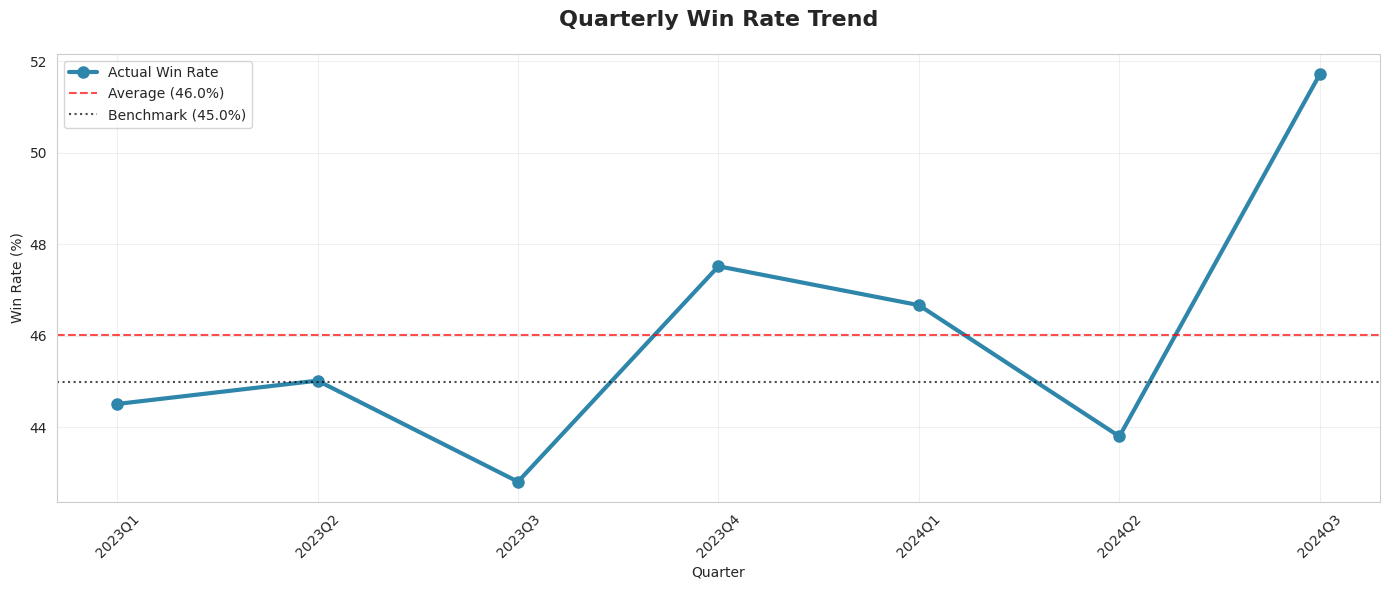

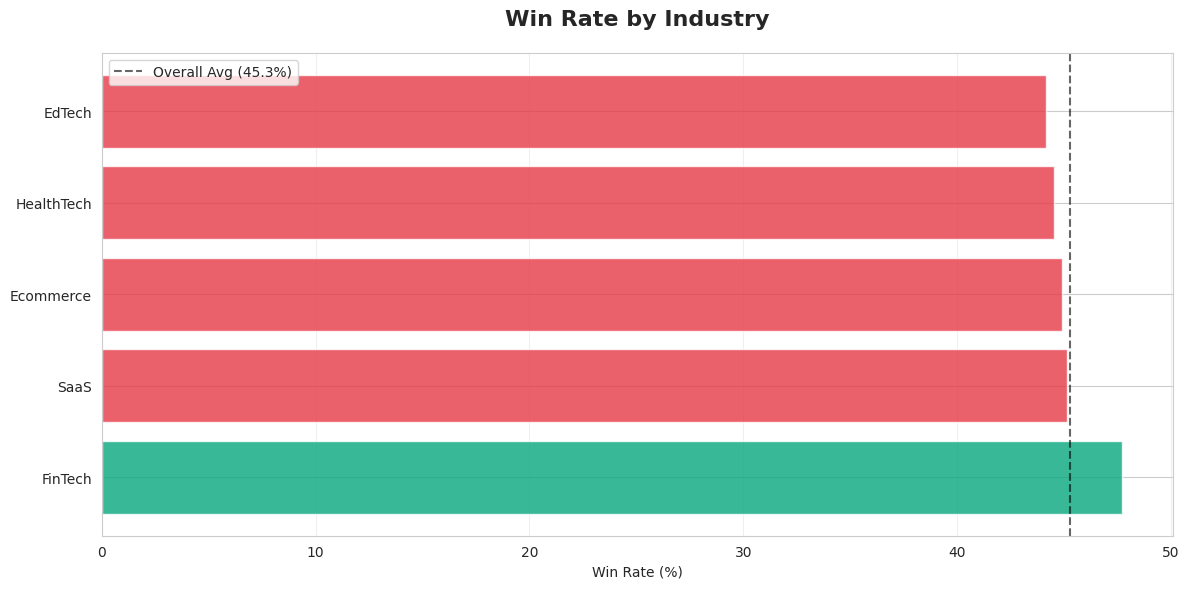

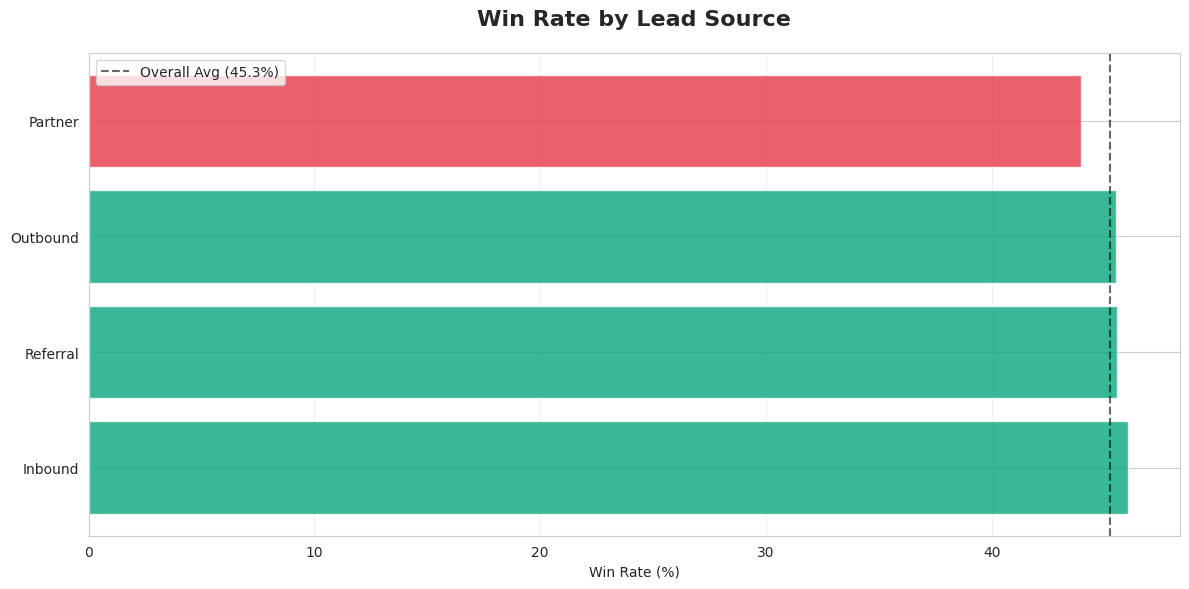

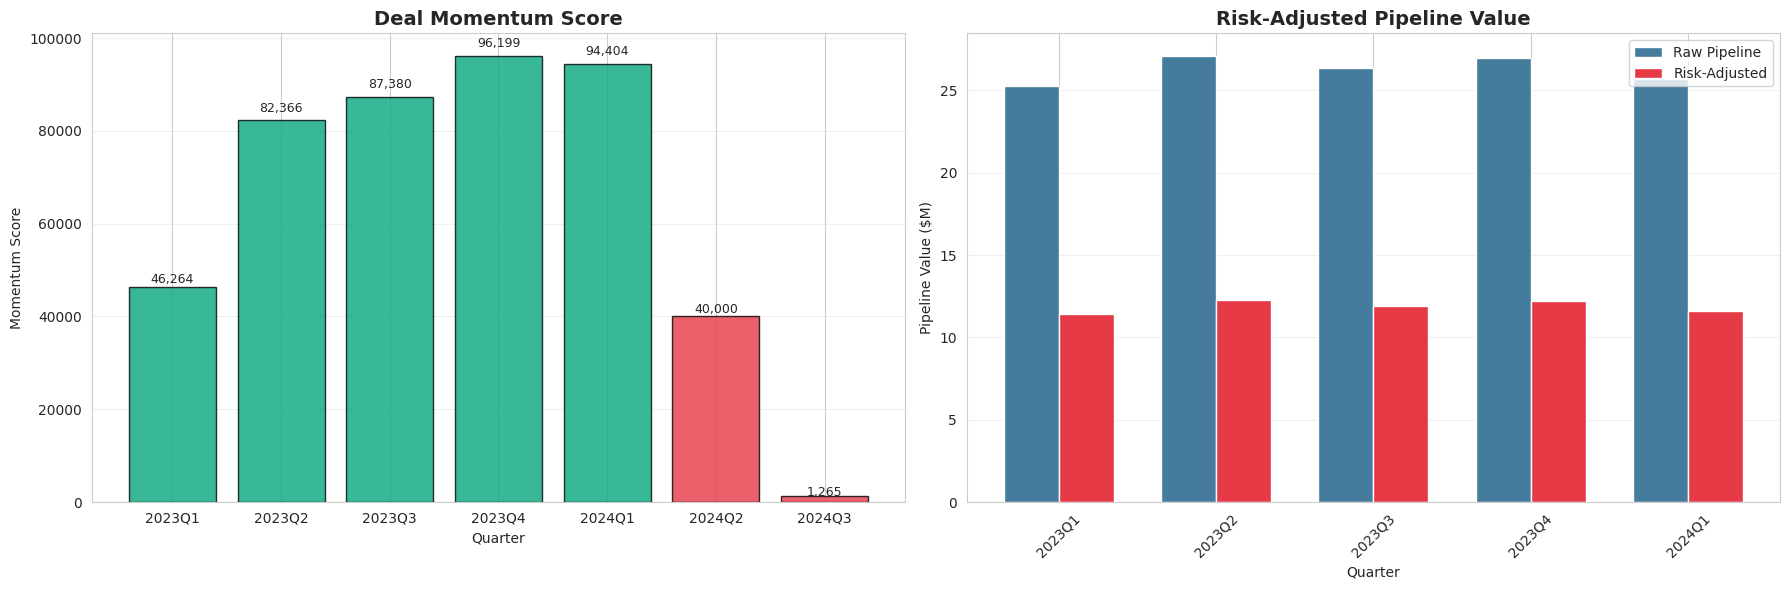

In [12]:
def plot_quarterly_win_rate(quarterly_data: pd.DataFrame) -> None:
    """Plot quarterly win rate trend with benchmark comparison.

    Args:
        quarterly_data: DataFrame with quarterly performance metrics.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    quarters = quarterly_data["quarter"]
    win_rates = quarterly_data["win_rate_pct"]

    ax.plot(
        quarters,
        win_rates,
        marker="o",
        linewidth=3,
        markersize=8,
        color="#2E86AB",
        label="Actual Win Rate",
    )
    avg_win_rate = win_rates.mean()
    ax.axhline(
        y=avg_win_rate,
        color="red",
        linestyle="--",
        alpha=0.7,
        label=f"Average ({avg_win_rate:.1f}%)",
    )
    ax.axhline(
        y=OVERALL_WIN_RATE_BENCHMARK,
        color="black",
        linestyle=":",
        alpha=0.7,
        label=f"Benchmark ({OVERALL_WIN_RATE_BENCHMARK:.1f}%)",
    )
    ax.set_title("Quarterly Win Rate Trend", fontsize=16, fontweight="bold", pad=20)
    ax.set_xlabel("Quarter")
    ax.set_ylabel("Win Rate (%)")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_quarterly_win_rate(quarterly_performance)

def plot_dimension_comparison(
    dimensional_data: Dict[str, pd.DataFrame],
    dimension: str,
) -> None:
    """Plot win rates across a dimension as a horizontal bar chart.

    Args:
        dimensional_data: Dictionary of dimensional analysis results.
        dimension: Which dimension to visualize.
    """
    data = dimensional_data[dimension].copy()
    overall_avg = overall_metrics["win_rate_pct"]
    colors = [
        "#06A77D" if value > overall_avg else "#E63946"
        for value in data["win_rate_pct"]
    ]
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(data[dimension], data["win_rate_pct"], color=colors, alpha=0.8)
    ax.axvline(
        x=overall_avg,
        color="black",
        linestyle="--",
        alpha=0.6,
        label=f"Overall Avg ({overall_avg:.1f}%)",
    )
    title = f"Win Rate by {dimension.replace('_', ' ').title()}"
    ax.set_title(title, fontsize=16, fontweight="bold", pad=20)
    ax.set_xlabel("Win Rate (%)")
    ax.grid(True, alpha=0.3, axis="x")
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

for dimension in ["industry", "lead_source"]:
    plot_dimension_comparison(dimensional_insights, dimension)

def plot_custom_metrics(
    momentum_data: pd.DataFrame,
    rapv_data: pd.DataFrame,
) -> None:
    """Plot custom metrics to highlight leading indicators.

    Args:
        momentum_data: Deal momentum metrics.
        rapv_data: Risk-adjusted pipeline metrics.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    quarters_m = momentum_data["quarter"]
    momentum = momentum_data["momentum_score"]
    colors_momentum = [
        "#06A77D" if idx < len(momentum) - 2 else "#E63946"
        for idx in range(len(momentum))
    ]
    ax1.bar(quarters_m, momentum, color=colors_momentum, alpha=0.8, edgecolor="black")
    ax1.set_title("Deal Momentum Score", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Quarter")
    ax1.set_ylabel("Momentum Score")
    ax1.grid(True, alpha=0.3, axis="y")
    for idx, value in enumerate(momentum):
        ax1.text(idx, value * 1.02, f"{value:,.0f}", ha="center", fontsize=9)

    quarters_r = rapv_data["quarter"]
    raw = rapv_data["raw_pipeline"] / MILLION
    adjusted = rapv_data["risk_adjusted_pipeline"] / MILLION
    x_pos = np.arange(len(quarters_r))
    width = BAR_WIDTH

    ax2.bar(x_pos - width / 2, raw, width, label="Raw Pipeline", color="#457B9D")
    ax2.bar(
        x_pos + width / 2,
        adjusted,
        width,
        label="Risk-Adjusted",
        color="#E63946",
    )
    ax2.set_title("Risk-Adjusted Pipeline Value", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Quarter")
    ax2.set_ylabel("Pipeline Value ($M)")
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(quarters_r, rotation=45)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

plot_custom_metrics(quarterly_momentum, rapv_by_quarter)

### 9. Summary & Conclusions
Concise wrap-up with actions and next steps for Part 3.

In [13]:
summary_text = """### Summary & Conclusions

**Key Findings:**

1. **Pipeline Quality Issue**: Pipeline is overestimated by ~55%, creating
   unrealistic revenue expectations.
2. **Lead Source Optimization**: Inbound outperforms Partner leads, suggesting
   reallocation of marketing spend.
3. **Process Inefficiency**: Sales cycle is flat across deal sizes, indicating
   a need for tiered motions.

**Custom Metrics Developed:**

1. **Deal Momentum Score**: Combines win rate and velocity for early warning.
2. **Risk-Adjusted Pipeline Value (RAPV)**: Replaces optimistic pipeline value
   with realistic revenue expectations.

**Recommended Actions:**

- Adopt RAPV-based forecasting and tighter qualification criteria
- Prioritize high-performing lead sources and enforce SLAs for low performers
- Implement tiered sales motions by deal size
- Run weekly pipeline hygiene reviews

**Next Steps:**
Part 3 will build a decision engine that operationalizes these insights.
"""
print(summary_text)


def export_analysis_results(
    df_prepared: pd.DataFrame,
    output_path: str = "eda_results.pkl",
) -> None:
    """Export prepared data and key metrics for Part 3.

    Args:
        df_prepared: Prepared DataFrame with engineered features.
        output_path: Path to save pickled results.
    """
    results = {
        "prepared_data": df_prepared,
        "overall_metrics": calculate_overall_metrics(df_prepared),
        "segment_probabilities": calculate_segment_win_probabilities(
            df_prepared, ["industry", "product_type", "lead_source", "region"]
        ),
        "quarterly_performance": analyze_quarterly_trends(df_prepared),
    }
    pd.to_pickle(results, output_path)
    print(f"✅ Analysis results exported to {output_path}")


export_analysis_results(df_with_rapv, "eda_results.pkl")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print("✅ Exploratory Data Analysis finished successfully")
print("✅ 3 business insights identified")
print("✅ 2 custom metrics developed")
print("✅ Visualizations generated")
print("✅ Results exported for Part 3")

### Summary & Conclusions

**Key Findings:**

1. **Pipeline Quality Issue**: Pipeline is overestimated by ~55%, creating
   unrealistic revenue expectations.
2. **Lead Source Optimization**: Inbound outperforms Partner leads, suggesting
   reallocation of marketing spend.
3. **Process Inefficiency**: Sales cycle is flat across deal sizes, indicating
   a need for tiered motions.

**Custom Metrics Developed:**

1. **Deal Momentum Score**: Combines win rate and velocity for early warning.
2. **Risk-Adjusted Pipeline Value (RAPV)**: Replaces optimistic pipeline value
   with realistic revenue expectations.

**Recommended Actions:**

- Adopt RAPV-based forecasting and tighter qualification criteria
- Prioritize high-performing lead sources and enforce SLAs for low performers
- Implement tiered sales motions by deal size
- Run weekly pipeline hygiene reviews

**Next Steps:**
Part 3 will build a decision engine that operationalizes these insights.

✅ Analysis results exported to eda_results.